# Week 5: Context-free languages

In [1]:
from tock import *

# Tuesday

We're beginning the second unit of the course, in which we look at _context-free grammars_ and _pushdown automata_. Recall that in the first class we briefly introduced Turing machines, and then introduced finite automata as being like Turing machines but restricted to have only a one-way, read-only tape. Pushdown automata are a little bit less restricted: they have a one-way, read-only tape, but they also have a stack. But the book starts with context-free grammars, probably because they're a little more familiar and/or easier to understand.

## Context-free grammars

<div class="alert alert-info">
    <p><b>Read</b> Section 2.1, but skip "Chomsky Normal Form."</p>
    <p><b>Watch</b> <a href="https://notredame.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=acb2d548-a067-4c4a-b204-ac1500ea9630">W5E1: Context-Free Grammars</a>.</p>
</div>

Context-free grammars were invented in the late 1950s by Noam Chomsky as a way of describing the syntax of human languages (he called them *phrase-structure grammars*). Later, they were appropriated by the inventors of the programming language ALGOL-60 as a way to describe that language's syntax (which came to be called *Backus-Naur form*).

We can start with a simpler example than the book's.

In [2]:
g1 = Grammar.from_lines([
    'S -> a S b',
    'S -> &'
])
g1

This grammar has two *rules* (also called *productions*) of the form $A \rightarrow \beta$, where $A$ is called the *left-hand side* (lhs) and $\beta$ is called the *right-hand side* (rhs).

A *derivation* of a grammar starts with the *start symbol*, which in this case is $\text{S}$. Then, if there is a rule $A \rightarrow \beta$, you can rewrite an occurrence of $A$ with $\beta$. Repeat until no more rewriting can be done. For example,
\begin{align*}
\text{S} &\Rightarrow \mathtt{a} \text{S} \mathtt{b} && \text{using the first rule} \\
&\Rightarrow \mathtt{aa} \text{S} \mathtt{bb} && \text{using the first rule} \\
&\Rightarrow \mathtt{aabb} && \text{using the second rule}
\end{align*}
Another example:
\begin{align*}
\text{S} &\Rightarrow \mathtt{a} \text{S} \mathtt{b} && \text{using the first rule} \\
&\Rightarrow \mathtt{aa} \text{S} \mathtt{bb} && \text{using the first rule} \\
&\Rightarrow \mathtt{aaa} \text{S} \mathtt{bbb} && \text{using the first rule} \\
&\Rightarrow \mathtt{aaabbb} && \text{using the second rule}
\end{align*}

An alternative way to write derivations is as a *tree*:

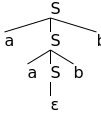

In [3]:
only_parse(g1, 'a a b b'.split())

Note that we draw a leaf node for $\varepsilon$ even though it is not a symbol of the string.

The symbols used in a CFG come in two kinds, *terminals* and *nonterminals*. Terminals are normally written with lowercase typewriter letters (e.g., $\texttt{a}$, $\texttt{b}$). The book calls nonterminals *variables* and it writes them with uppercase italic letters. I think it's confusing to call them variables, so I always call them nonterminals, and I try to write them with uppercase roman letters (e.g., $\text{A}, \text{B}$).

The start symbol is always a nonterminal. It is often $\text{S}$ but doesn't have to be. When you write a CFG, you should state what the start symbol is if it's anything other than $\text{S}$.

The left-hand side of a rule is always a single nonterminal, and the right-hand side is a string of terminals and nonterminals. (There are other kinds of grammars where the left-hand side doesn't have to be a single nonterminal; we may look at some in later units of the course.) Above, I said that a derivation stops when no more rewriting can be done. That's not strictly correct; a derivation stops when there are no more nonterminal symbols. (What's the difference?)

## A natural language example

As I mentioned above, CFGs were originally invented for natural language. [Generalized Phrase Structure Grammar](https://en.wikipedia.org/wiki/Generalized_phrase_structure_grammar) was an attempt to write a CFG for English. The [Berkeley Parser](https://github.com/slavpetrov/berkeleyparser) builds a CFG for English partly using human input and partly automatically.

Here's a CFG for a very small fragment of English:

In [4]:
%%file english.cfg
S -> NP VP
VP -> V NP
NP -> DT NN
NP -> DT JJ NN
NP -> NP that VP
VP -> V NP
DT -> a
NN -> cat
NN -> dog
JJ -> red
JJ -> blue
V -> saw
V -> ate

Overwriting english.cfg


In [5]:
g2 = Grammar.from_file('english.cfg')
g2

We can generate some random strings from it:

a red dog that ate a red dog saw a dog


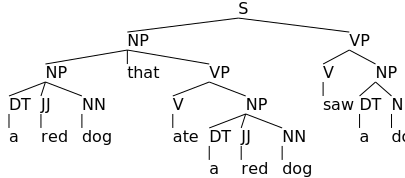

a cat that saw a dog that saw a dog that saw a dog that saw a dog that ate a blue dog that saw a red cat saw a cat that ate a blue dog


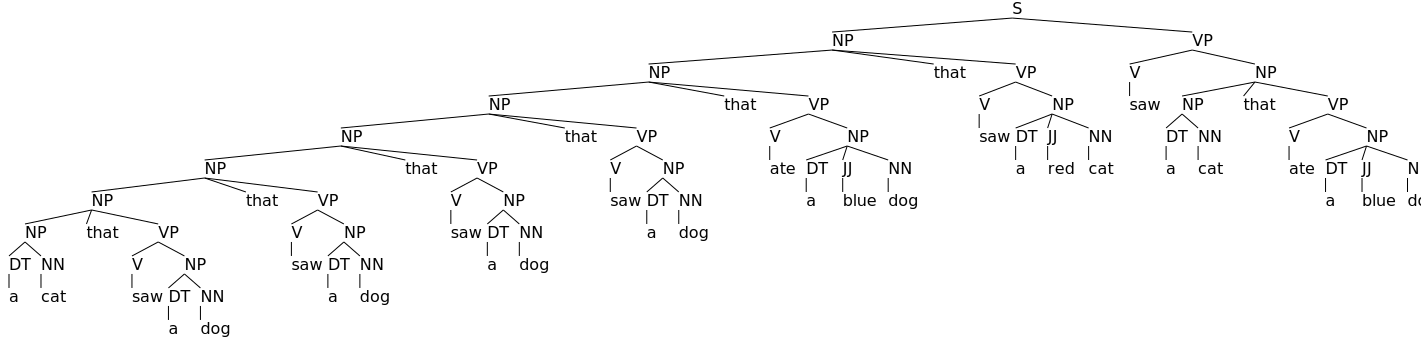

a blue cat ate a dog


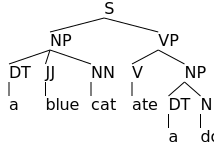

a blue dog ate a dog


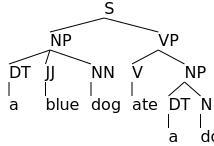

a red cat that ate a blue cat that ate a red dog that ate a red cat that ate a dog ate a cat


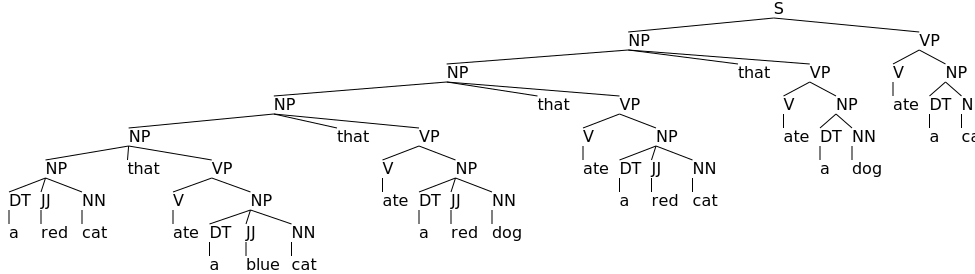

In [6]:
import random
def sample(g):
    """Generate a random string from a CFG."""
    rules = {n:[] for n in g.nonterminals}
    for lhs, rhs in g.rules:
        rules[lhs[0]].append(list(rhs))
    x = []
    y = [g.start_nonterminal]
    while len(y) > 0:
        a = y.pop(0)
        if a in g.nonterminals:
            y = random.choice(rules[a]) + y
        else:
            x.append(a)
    return x

for i in range(5):
    w = sample(g2)
    print(' '.join(w))
    display(any_parse(g2, w))

## A programming language example (optional)

<div class="alert alert-info"><p><b>Watch</b> <a href="https://notredame.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=704653ac-6f34-4755-9f0c-ac1500ea95ed">W5E2: CFGs and Operator Precedence</a> (optional).</p></div>

You can see a CFG for C in the [draft standard](http://www.open-std.org/jtc1/sc22/wg14/www/docs/n1570.pdf), starting on page 458, or as a [YACC grammar](http://www.quut.com/c/ANSI-C-grammar-y.html).

The book shows a CFG for arithmetic expressions. Let's imagine a simpler version first. Unfortunately Tock makes us write the symbols out as words:

In [7]:
g3 = Grammar.from_lines([
    'E -> E plus E',
    'E -> E times E',
    'E -> left E right',
    'E -> 3'
])
g3

This generates syntactically correct strings like $\texttt{3+3*3}$, but there's a problem. First, the grammar is *ambiguous* because there is more than one way to derive $\texttt{3+3*3}$:

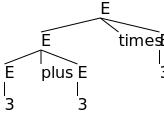

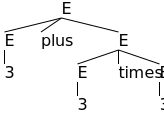

In [8]:
for tree in all_parses(g3, '3 plus 3 times 3'):
    display(tree)

Ambiguity is ubiquitous is natural language, but in programming languages, it is generally considered a bad thing.

Compilers and interpreters usually process syntax trees bottom-up: the translation or value of a node is computed from the translation/value of its children. So the natural interpretation of one of these trees is $3+(3\times3)=12$, while the natural interpretation of the other is $(3+3)\times3=18$. If we want the standard order of operations, we only want the former.

Various solutions to this problem exist, but the one that uses pure context free grammars is to add more nonterminal symbols to make the tree on the right impossible.

In [9]:
g4 = Grammar.from_lines([
    'E -> E plus T',
    'E -> T',
    'T -> T times F',
    'T -> F',
    'F -> left E right',
    'F -> 3'
])
g4

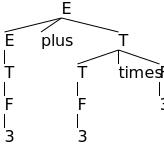

In [10]:
only_parse(g4, '3 plus 3 times 3')

## Pushdown automata

<div class="alert alert-info">
    <p><b>Read</b> Section 2.2, up to but not including "Equivalence with Context-Free Grammars".</p>
    <p><b>Watch</b> <a href="https://notredame.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=2c7fdf16-c20c-4cff-b289-ac1500ea959a">W5E3: Pushdown Automata</a>.</p>
</div>

Pushdown automata are equipped with, in addition to the input tape, a *pushdown store*, said to have been inspired by the tray dispenser in a university dining hall. Nowadays, a pushdown store is more commonly known as a stack, which you should be quite familiar with. Here's an example (2.14):

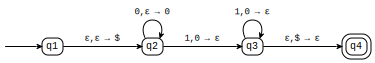

In [11]:
m1 = read_csv("pda-m1.csv")
m1

As with NFAs, we have states, including a start state and accept states, and transitions. But the transition labels are different. They're of the form $a, x \rightarrow y$ where $a$ is the input symbol to read, $x$ is the stack symbol to pop, and $y$ is the stack symbol to push. The PDA can follow the transition if $a$ is the next input symbol and $x$ is the top stack symbol. When it does, it consumes $a$, pops $x$, and pushes $y$.

Let's look at an example run. This happens to be a deterministic PDA.

In [30]:
run(m1, "0 0 0 1 1 1", show_stack=4).only_path()

q1,[0] 0 0 1 1 1,ε
q2,[0] 0 0 1 1 1,$
q2,[0] 0 1 1 1,[0] $
q2,[0] 1 1 1,[0] 0 $
q2,[1] 1 1,[0] 0 0 $
q3,[1] 1,[0] 0 $
q3,1,[0] $
q3,ε,$
q4,ε,ε


This table shows the state in the first column, the input in the second column (next symbol in square brackets), and the stack in the third column (top symbol in square brackets).

More examples from the book:

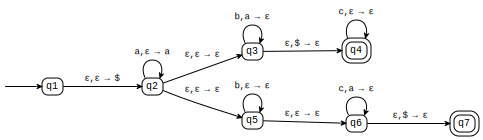

In [13]:
m2 = read_csv("pda-m2.csv")
m2

**Question.** Does the above PDA accept the strings $\mathtt{aabb}$? $\mathtt{aabc}$? $\mathtt{aacc}$?

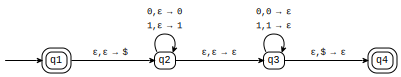

In [14]:
m3 = read_csv("pda-m3.csv")
m3

Let's look at a run of this PDA, which is nondeterministic, so we draw it as a graph:

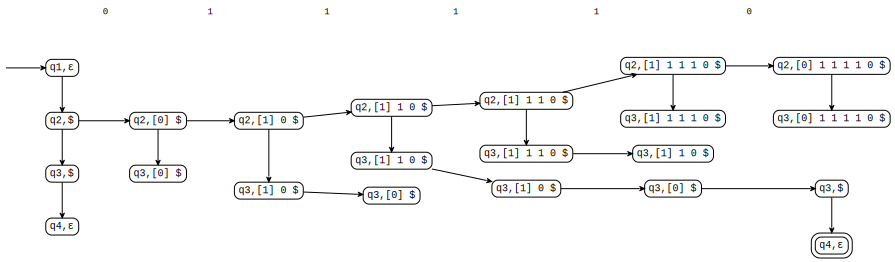

In [31]:
run(m3, "0 1 1 1 1 0", show_stack=7)

**Question.** Design a PDA that recognizes the language of matching left and right parentheses (like Example 2.3).

**Question.** Design a PDA that recognizes the language over $\Sigma = \{\mathtt{a}, \mathtt{u}, \mathtt{c}, \mathtt{g}\}$ such that every symbol is paired with exactly one other symbol -- $\mathtt{a}$ with $\mathtt{u}$ and $\mathtt{c}$ with $\mathtt{g}$, and the pairings are nested like parentheses in the previous question.